## BC205 Exercise 2: Discovering and Evaluating Hidden Motifs in Sequences

**Author:** Georgios Kousis Tsampazis

---
### Overview
For your second exercise you will need to implement the Gibbs Sampler for motif discovery in the language of your choice.
### Part 1: Motif Discovery with Gibbs Sampling

1. **Implement the Gibbs Sampler** 
2. **Use a free parameter for the size k of the motif you will be searching for**
3. **Repeat the search for various values of k (e.g. from k=3 to k=7)**

**Expected Output:**  
- Result 1: Return the discovered motifs as PWMs.

### Part 2: Information Content Calculation

1. **Calculate the Information Content of the discovered PWMs for each k**

**Expected Output:**  
- Result 2: Report the k and the motif with the greatest (scaled) Information Content.

---

## Notebook Instructions

To ensure reproducibility and clarity, structure your Jupyter notebook as follows:



1. ### Data Preparation
   - **Download or Load the Genome Dataset**: Use the [link]("https://raw.githubusercontent.com/geokousis/Intro-Python/refs/heads/main/motifs_in_sequence.fa") to obtain the *sequence dataset*, or run the provided code to create a data_tmp directory with the dataset file. Also install Notebook dependencies.

2. ### Parts
   - **Downlaod data** (optional *see 1*)
   - **Set PWM Function**
   - **Set Gibbs Sampler Function**
   - **Set Plotting Logos Function**
   - **Run Batch Gibbs Sampling Across Motif Lengths**

4. ### Results and Visualization
   - **Result 1:** Display Logo plots for all the given length `k` for the best found motif for k. 
   - **Result 2:** Display the most probable motif across all k and its logo
---

*Happy motif hunting!*


### Noteboook dependencies
*As always a conda enviroment is recommended for easier installation*

In [3]:
pip install tqdm requests numpy logomaker pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


### Downlaod data

In [8]:
import os
import requests
from tqdm import tqdm

# Create the data directory if it doesn't exist.
data_dir = "./data_tmp"
os.makedirs(data_dir, exist_ok=True)
files_to_download = {
    "motifs_in_sequence.fa": "https://raw.githubusercontent.com/geokousis/Intro-Python/refs/heads/main/motifs_in_sequence.fa",
}

def download_file(url, file_path):
    response = requests.get(url, stream=True)
    response.raise_for_status()  # Raise an error for bad status codes.
    
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte blocks

    with open(file_path, 'wb') as file, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=os.path.basename(file_path)
        ) as progress_bar:
        for data in response.iter_content(block_size):
            file.write(data)
            progress_bar.update(len(data))

for filename, url in files_to_download.items():
    file_path = os.path.join(data_dir, filename)
    if not os.path.exists(file_path):
        print(f"Downloading {filename} ...")
        try:
            download_file(url, file_path)
            print(f"{filename} downloaded successfully.")
        except Exception as e:
            print(f"Error downloading {filename}: {e}")
    else:
        print(f"{filename} already exists. Skipping download.")
print("Files are ready.")


motifs_in_sequence.fa already exists. Skipping download.
Files are ready.


### Open the 50 short sequences

In [ ]:
motifs_sequences = []
with open("./data_tmp/motifs_in_sequence.fa", "r") as file:
    for line in file:
        motifs_sequences.append(line.strip())

### PWM Function
**Function:** `pwm(motifs)`

**Purpose:**  
The `pwm` function takes a list of equal‐length DNA motifs and returns:

**Parameters:** 
- `motifs` (`List[str]`): List of same-mer motifs

**Returns:**  
1. **Position Weight Matrix (PWM)**  
   - A 4×k array (`pwm_matrix`) giving the frequency of each nucleotide (A, C, G, T) at each position.  
   - Rows correspond to nucleotides in the order A, C, G, T columns correspond to motif positions.

2. **Shannon Information Content**  
   - A length-k vector (`info`) where each entry is the information content (in bits) at that position:  


**Usage Example**  
```python
motifs = ["ACGT", "AGGT", "ACCT", "AGCT"]
matrix, info = pwm(motifs)


In [ ]:
import numpy as np
# PWM and info (Shannon information (in bits)) content calculation
def pwm(motifs):
    k = len(motifs[0]) # Expects Equal size kmers 
    pwm_matrix = np.zeros((4, k))
    nuc_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3} # Please keep constant or bad things will happen :P 
    for motif in motifs:
        for i, nuc in enumerate(motif):
            pwm_matrix[nuc_index[nuc], i] += 1 # Move column, select row (nucleotide)
    pwm_matrix = pwm_matrix / len(motifs) # Normalize 
    
    # Calculate info (Shannon)
    info = np.zeros(k)
    for i in range(k):
        for j in range(4):
            p = pwm_matrix[j, i]  # probability of nucleotide j at position i
            if p > 0:
                info[i] += p * np.log2(p) # -H 
        info[i] = 2 + info[i]  # 2 - (negative entropy)

    return pwm_matrix, info

### Gibbs Sampler

**Function:** `Gibbs_sampler(sequences, k=3, max_iter=1000, patience=100, tol=1e-4, seed=7)`

**Purpose:**  
Refine a set of k-mer motifs across multiple DNA sequences using Gibbs sampling. Iteratively updates one motif at a time to maximize Shannon information content, with early stopping upon convergence.

**Parameters:**  
- `sequences` (`List[str]`): DNA sequences to analyze.  
- `k` (`int`, default=3): Length of each motif (k-mer).  
- `max_iter` (`int`, default=1000): Maximum number of sampling iterations.  
- `patience` (`int`, default=100): Consecutive iterations of minimal change before early stopping.  
- `tol` (`float`, default=1e-4): Threshold for change in total information content to count as “stable.”  
- `seed` (`int`, default=7): Random seed for reproducible/deterministic initialization.
- `verbose` (`bool`, default=False): Parameter to set the verbosity of the function. True will print if no convergency was achieved.

**Returns:**  
1. `motifs` (`List[str]`): Final refined k-mer for each sequence.  
2. `final_pwm` (`np.ndarray` of shape `(4, k)`): Position weight matrix of nucleotide frequencies (A, C, G, T).  
3. `final_info` (`np.ndarray` of length `k`): Per-position Shannon information content in bits.

**Algorithm Steps:**  
1. **Initialization**  
   - Randomly select one k-mer from each sequence.  
2. **Gibbs Sampling Loop** (up to `max_iter`):  
   - Randomly exclude one sequence.  
   - Build a PWM from the remaining motifs and compute its total information content.  
   - Slide a window of length `k` along the omitted sequence, scoring each k-mer by PWM probability.  
   - Update the omitted sequence’s motif to the highest-scoring k-mer. *This step is a little controversial (see below)*
   - If the change in total information content is below `tol`, increment a stability counter; otherwise reset it.  
   - If the stability counter reaches `patience`, break early.  
3. **Finalization**  
   - Construct and return the PWM and information content profile from the final motifs.

**Usage Example:**  
```python
motifs, pwm_matrix, info_profile = Gibbs_sampler(seqs, k=5, max_iter=500)
```
**side note** 

`Update the omitted sequence’s motif to the highest-scoring k-mer.` **This step is a little controversial...it can lead to local stability but this algorithm is meant to be runned multiple independent times (different seed) so it adjusts to that. Cause of this Step this is more like a Greedy Gibbs Sampling, but I guess there is some subjectivity in naming algorithms. I prefect this way... it adds a deterministic step in the whole stohastic approach, which is nothing special but kinda cool!**


In [1]:
import random
import numpy as np

def Gibbs_sampler(sequences, k=3, max_iter=1000, patience=100, tol=1e-4, seed=7,verbose=False):
    """ Gibbs sampler function """
    random.seed(seed) # Set to have deterministic Results 
    nuc_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3} # 20 years of bad luck if u change it 
    n = len(sequences)
    motifs = []
    # Choose one random motif per sequence
    for seq in sequences:
        rand_start = random.randint(0, len(seq) - k)
        motifs.append(seq[rand_start:rand_start + k])
    # Variables for convergence 
    prev_info_sum = 0
    stable_count = 0
    # To scare for a while loop 
    for iteration in range(max_iter):
        i = random.randint(0, n - 1)
        left_out_seq = sequences[i] # see variable name 
        other_motifs = motifs[:i] + motifs[i+1:]
        pwm_matrix, info = pwm(other_motifs) # Call of pwm function for the model building motifs (seqs) (not for i)
        info_sum = np.sum(info)
        # Find best motif according to the model for the left out sequence
        best_score = -1
        best_motif = None
        for j in range(len(left_out_seq) - k + 1):
            kmer = left_out_seq[j:j + k]
            score = sum(pwm_matrix[nuc_index[base], pos] for pos, base in enumerate(kmer))
            if score > best_score:
                best_score = score
                best_motif = kmer
        motifs[i] = best_motif # replace motif for sequence i with highest-scoring k-mer under current PWM
        
        # Convergence (no info improvment)
        if abs(info_sum - prev_info_sum) < tol:
            stable_count += 1
        else:
            stable_count = 0
        if stable_count >= patience:
            break
        prev_info_sum = info_sum
    else:# Just learnt about this it's cool... if for loop doesnt break -->else content
        if verbose: 
            print("No convergence")
    final_pwm, final_info = pwm(motifs) # recompute PWM & info on final set of motifs
    return motifs, final_pwm, final_info

### Plotting LOGOS

**Function:** `plot_logo(pwm_matrix, k)`

**Purpose:**  
The `plot_logo` function generates a sequence logo from a PWM using Logomaker:

- **Imports**  
  - `logomaker` for drawing the logo  
  - `pandas` to structure the PWM as a DataFrame *(logomaker requirment)*
  - `matplotlib.pyplot` for figure handling  

**Parameters:**  
- `pwm_matrix` (`np.ndarray`): Position weight matrix of nucleotide frequencies 
- `k` (`int`): Length of motif (k-mer).  

**Returns:**  
1. **An ugly plot**

**Usage Example**  
  ```python
  def plot_logo(pwm_matrix, k):


In [35]:
import logomaker
import pandas as pd
import matplotlib.pyplot as plt

# Plot sequence logo using Logomaker
def plot_logo(pwm_matrix, k):
    bases = ['A', 'C', 'G', 'T']
    pwm_df = pd.DataFrame(pwm_matrix.T, columns=bases)
    plt.figure(figsize=(k, 3))
    logomaker.Logo(pwm_df, color_scheme='classic')
    plt.title(f"Motif Logo for k = {k}")
    plt.xlabel("Position")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

### Batch Gibbs Sampling Across Motif Lengths

**Function:** `run_gibbs_multiple(sequences, k_range=range(3, 8), runs=200)`

**Purpose:**  
Evaluate motifs for a range of lengths `k` by running multiple Gibbs-sampler trials per k, track the best motif per length and identify the overall best based on scaled information content `(IC/k)`.

**Parameters:**  
- `sequences (List[str])`: DNA sequences to scan.
- `k_range (range, default range(3, 8))`: Motif lengths to evaluate (e.g., 3–7).
- `runs (int, default=200)`: Number of independent Gibbs-sampler trials per k.

**Returns:**  
**Nothing it just prints some stuff**
1. Displays sequence logos through `plot_logo` and best IC/k per k.
2. Prints the globally optimal k , its IC/k, and sample motifs, so the most probable motif across all k.

**Usage Example:**  
```python
run_gibbs_multiple(sequences, k_range=range(3,8), runs=200)
```
**side note** 

`Update the omitted sequence’s motif to the highest-scoring k-mer.` **This is the part in which we fix for this thingy**



Running Gibbs sampler for k = 3


Gibbs Trials (k=3): 100%|██████████| 200/200 [00:10<00:00, 19.04it/s]


Best motif for k = 3:
   Information content / k: 1.9529
     Sample motifs: ['CAT', 'GAT', 'GAT'] ...


<Figure size 300x300 with 0 Axes>

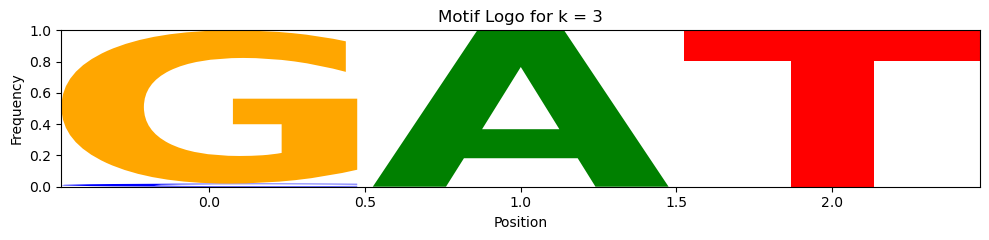


Running Gibbs sampler for k = 4


Gibbs Trials (k=4): 100%|██████████| 200/200 [00:12<00:00, 15.83it/s]


Best motif for k = 4:
   Information content / k: 1.7591
     Sample motifs: ['TATA', 'GATA', 'GATA'] ...


<Figure size 400x300 with 0 Axes>

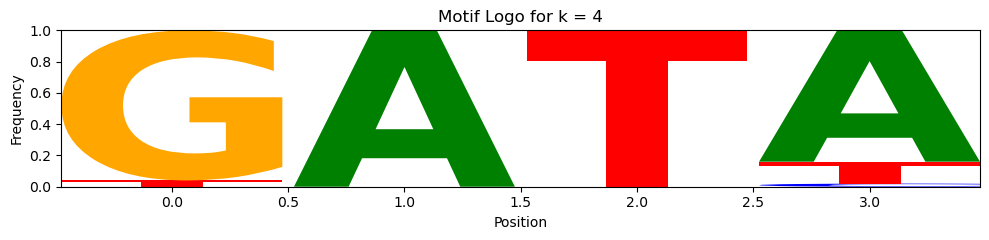


Running Gibbs sampler for k = 5


Gibbs Trials (k=5): 100%|██████████| 200/200 [00:14<00:00, 13.46it/s]



Best motif for k = 5:
   Information content / k: 1.5067
     Sample motifs: ['AGAGT', 'AGATA', 'AGATA'] ...


<Figure size 500x300 with 0 Axes>

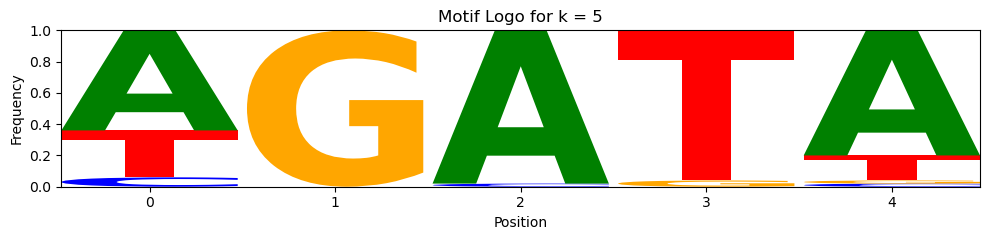


Running Gibbs sampler for k = 6


Gibbs Trials (k=6): 100%|██████████| 200/200 [00:17<00:00, 11.65it/s]



Best motif for k = 6:
   Information content / k: 1.3142
     Sample motifs: ['TTATAG', 'AGATAT', 'AGATAG'] ...


<Figure size 600x300 with 0 Axes>

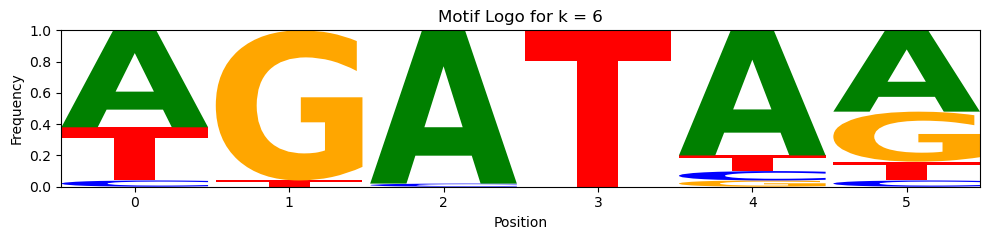


Running Gibbs sampler for k = 7


Gibbs Trials (k=7): 100%|██████████| 200/200 [00:19<00:00, 10.42it/s]



Best motif for k = 7:
   Information content / k: 1.1363
     Sample motifs: ['TTATAGA', 'ATATAAG', 'AGATAGG'] ...


<Figure size 700x300 with 0 Axes>

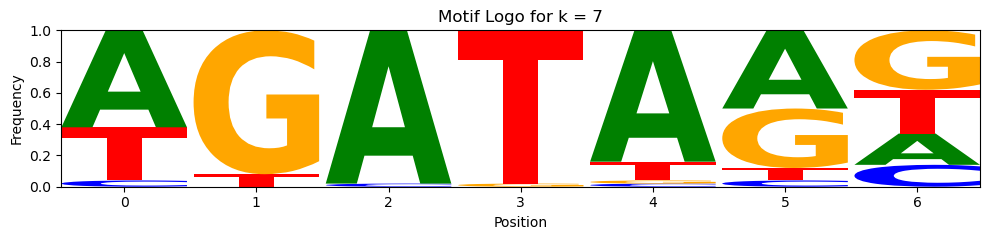


Most probable motif across all k:
   Best k: 3
   Information content / k: 1.9529
   Sample motifs: ['CAT', 'GAT', 'GAT'] ...


<Figure size 300x300 with 0 Axes>

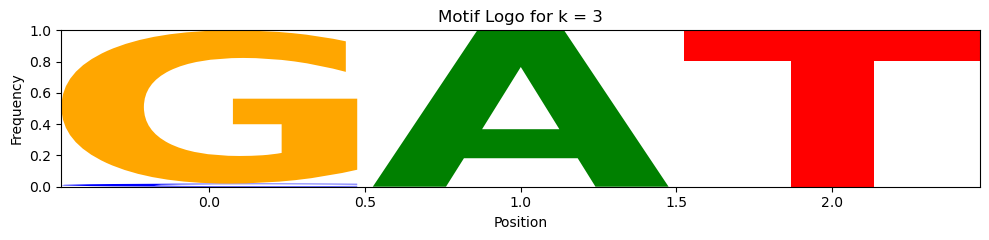

In [ ]:
from tqdm import trange

def run_gibbs_multiple(sequences, k_range=range(3, 8), runs=200):
    best_global_info_per_k = -1
    best_global_k = None
    best_global_pwm = None
    best_global_motifs = None

    for k in k_range:
        best_info_sum = -1
        best_info_per_k = -1
        best_pwm = None
        best_motifs = None

        print(f"\nRunning Gibbs sampler for k = {k}")
        for i in trange(runs, desc=f"Gibbs Trials (k={k})"):
            motifs, pwm_matrix, info = Gibbs_sampler(sequences, k=k, seed=i,max_iter=300)
            info_sum = np.sum(info)
            info_per_k = info_sum / k # scaled as insrtucted

            if info_per_k > best_info_per_k:
                best_info_sum = info_sum
                best_info_per_k = info_per_k
                best_pwm = pwm_matrix
                best_motifs = motifs
        # Printigs
        print(f"\nBest motif for k = {k}:")
        print(f"   Information content / k: {best_info_per_k:.4f}")
        print("     Sample motifs:", best_motifs[:3], "...") # Just 3
        plot_logo(best_pwm, k)
        
        # Track global best across all k
        if best_info_per_k > best_global_info_per_k:
            best_global_info_per_k = best_info_per_k
            best_global_k = k
            best_global_pwm = best_pwm
            best_global_motifs = best_motifs

    # Final summary
    print("="*100) # Need to find better ways to sections things 
    print("\nMost probable motif across all k:")
    print(f"   Best k: {best_global_k}")
    print(f"   Information content / k: {best_global_info_per_k:.4f}")
    print(f"   Sample motifs: {best_global_motifs[:3]} ...")
    plot_logo(best_global_pwm, best_global_k)
run_gibbs_multiple(motifs_sequences)


---
## **Results**
##### From our analysis, the Gibbs sampler most frequently identifies **GAT** as the top motif under default settings (or `max_itter=300`). However, when we vary the `max_iter` parameter, the algorithm sometimes converges on different triplets. In contrast, the longer pattern **GATA** is both more stable across runs and better supported by biological context. Therefore, despite the initial prominence of “GAT,” we can safely conclude that **GATA** is the most reliable and biologically relevant motif. 
*Must be Noted while running the sampling with `verbose=True`, very few of the independent inits converged and didn't stop cause of the max itter :(*